In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches
plt.rcParams["axes.grid"] = False

import seaborn as sns; sns.set()
import numpy as np
import pandas as pd

from util import GMMModel

import torch.nn
import torch.nn.functional as F
import torch.optim
import torch.utils.data

import scipy

import os
import json

os.environ['KMP_DUPLICATE_LIB_OK']='True'

Generate random $f, \vec{\mu}, C$ for each Gaussian model, where the model is <br><br>
$M_{ij} = \sum_{k=1}^{n=ngauss} f G_k(\mu_1, \mu_2, \sigma_1, \sigma_2, \rho)$ <br><br>
Set $f = 1, \sigma_1 = \sigma_2 = 5, \rho = 0.5$ for each GMM. <br><br>
Simulate $D_{ij} = M_{ij} + N_{ij}$, where $N_{ij} \sim G(\sigma = W_{ij}^{-0.5}).$ 

In [2]:
def data_sample(x1, x2, gen, ngauss=1, n=1000):
    
    x1_edges, x2_edges = np.arange(0, x1), np.arange(0, x2)

    x1_mid = len(x1_edges) // 2
    x2_mid = len(x2_edges) // 2
    
    GMM = GMMModel(x1_edges, x2_edges)
    
    data_shape = (n, ) + (len(x1_edges)-1, len(x2_edges)-1)
    params_shape = (n, ) + (ngauss, 5)
    
    data = np.zeros(shape=data_shape)
    params = np.zeros(shape=params_shape)
    
    for i in range(n):
        for g in range(ngauss):
              
            f = 1. / ngauss
            sigma1 = gen.lognormal(mean=1.3, sigma=0.3)
            sigma2 = gen.lognormal(mean=1.3, sigma=0.3)
            rho = gen.uniform(low=-0.8, high=0.8)
            rho = np.arctan(rho)
            
            assert sigma1 >= 0
            assert sigma2 >= 0
            assert -1.0 <= rho <= 1.0

            mu1 = gen.uniform(low=x1_edges[x1_mid-15], high=x1_edges[x1_mid+15])
            mu2 = gen.uniform(low=x2_edges[x2_mid-15], high=x2_edges[x2_mid+15])

            gmm_params = np.array([f, mu1, mu2, sigma1, sigma2, rho])
            
            model = GMM.predict(gmm_params, compute_partials=False)
            noise = gen.normal(loc=0.0, scale=0.001, size=(model.shape))
            
            data[i] += model + noise
            params[i][g] = gmm_params[1:6]
        
    # Flatten the data
    data = data.reshape(n, -1)
    params = params.reshape(n, -1)
    
    return (data, params)

# Generate training and testing data and save them

In [3]:
def save_data(seed=123):

    for i, file in enumerate(['x_train.pt', 'y_train.pt', 'x_test.pt', 'y_test.pt']):
       
        if not os.path.exists(file):
            break
        
        if i == 3:
            print('Data already exists')
            return 
    
    N_train, N_test = 100000, 100000
    gen = np.random.RandomState(seed=seed)

    x_train, y_train = data_sample(41, 41, gen, ngauss=1, n=N_train)
    x_test, y_test = data_sample(41, 41, gen, ngauss=1, n=N_test)

    # For torch
    x_train, y_train = torch.tensor(x_train.astype(np.float32)), torch.tensor(y_train.astype(np.float32)) 
    x_test, y_test = torch.tensor(x_test.astype(np.float32)), torch.tensor(y_test.astype(np.float32)) 

    torch.save(x_train, 'x_train.pt')
    torch.save(y_train, 'y_train.pt')
    torch.save(x_test, 'x_test.pt')
    torch.save(y_test, 'y_test.pt')
    print('Finished generating data')
            
    
save_data()

Data already exists


# Load Data

In [4]:
for i, file in enumerate(['x_train.pt', 'y_train.pt', 'x_test.pt', 'y_test.pt']):
    if not os.path.exists(file):
        print("{file} doesn't exists.".format(file=file))
        raise 

    if i == 3:
        break 

x_train, y_train = torch.load('x_train.pt'), torch.load('y_train.pt')
x_test, y_test = torch.load('x_test.pt'), torch.load('y_test.pt')

print('Loaded Data')

torch_train_data = torch.utils.data.TensorDataset(x_train, y_train)
torch_test_data = torch.utils.data.TensorDataset(x_test, y_test)

Loaded Data


In [5]:
def plot_data(x, y, seed=123):
    
    assert x.shape[0] == y.shape[0]
    
    gen = np.random.RandomState(seed=seed)
    arg = gen.randint(0, x.shape[0])
    
    size = int(np.sqrt(x.shape[1]))
    
    plt.imshow(x[arg].reshape(size, size), origin='lower')
    plt.plot(*y[arg], 'x', ms=25)
    plt.xlabel('$\mu_1$')
    plt.ylabel('$\mu_2$')

def plot_multiple_data(x, y, y_pred, n=4):
    
    assert x.shape[0] == y.shape[0]
    assert y.shape == y_pred.shape
    
    fig, axs = plt.subplots(nrows=n, ncols=n, sharex='col', sharey='row', figsize=(10, 10))
    
    fig.text(0.5, 0.04, '$\mu_1$', ha='center')
    fig.text(0.04, 0.5, '$\mu_2$', va='center', rotation='vertical')
    size = int(np.sqrt(x.shape[1]))
    
    for i, data in enumerate(zip(x[:n**2], y[:n**2], y_pred[:n**2])):
            
        idx, j = i // n, i % n
        
        axs[idx, j].imshow(data[0].reshape(size, size), origin='lower', extent=[0, size, 0, size], cmap=plt.cm.magma)
        axs[idx, j].grid(False)
        axs[idx, j].plot(*data[1][0:2], 'w+', ms=30)

        if np.all(data[2]):
            axs[idx, j].plot(*data[2][0:2], 'gx', ms=30)

In [6]:
def plot_histogram(test, predicted):
    
    assert test.shape[1] == 5
    assert test.shape == predicted.shape
    
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
    fig.tight_layout()
    
    mu1, mu2, sigma1, sigma2, rho = (test - predicted).T
    
    for i, diff in enumerate([mu1, mu2, sigma1, sigma2, rho]):
        idx, j = i // 3, i % 3
        
        ax[idx, j].hist(diff, density=True, range=(-1, 1))
        
        if i == 0:
            xlabel = "$\mu_{test, 1" + "} - \mu_{pred, 1" + "}$"
        
        elif i == 1:
            xlabel = "$\mu_{test, 2" + "} - \mu_{pred, 2" + "}$"
            
        elif i == 2:
            xlabel = "$\sigma_{test, 1" + "} - \sigma_{pred, 1" + "}$"
            
        elif i == 3:
            xlabel = "$\sigma_{test, 2" + "} - \sigma_{pred, 2" + "}$"
            
        else:
            xlabel = "$\\rho_{test" + "} - \\rho_{pred" + "}$"
        
        ax[idx, j].set_xlabel(xlabel, fontsize=15)
        ax[idx, j].axvline(x=0, color='r', linestyle='--')
    
    fig.subplots_adjust(hspace=0.4)
    ax[1,2].set_axis_off()
    

In [36]:
def plot_scatter(test, predicted):
    
    assert test.shape[1] == 5
    assert test.shape == predicted.shape
    
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
    fig.tight_layout()
    
    
    for i in range(test.shape[1]):
        idx, j = i // 3, i % 3
        
        ax[idx, j].scatter(test[:, i], predicted[:, i], s=2, alpha=0.7)
        
        if i == 0:
            ylabel = "$\mu_{pred, 1" + "}$"
            xlable = "$\mu_{test, 1" + "}$"
        
        elif i == 1:
            ylabel = "$\mu_{pred, 2" + "}$"
            xlable = "$\mu_{test, 2" + "}$"
            
        elif i == 2:
            ylabel = "$\sigma_{pred, 1" + "}$"
            xlable = "$\sigma_{test, 1" + "}$"
            
        elif i == 3:
            ylabel = "$\sigma_{pred, 2" + "}$"
            xlable = "$\sigma_{test, 2" + "}$"
            
        else:
            ylabel = "$\\rho_{pred" + "}$"
            xlable = "$\\rho_{test" + "}$"
        
        ax[idx, j].set_ylabel(ylabel, fontsize=15)
        ax[idx, j].set_xlabel(xlable, fontsize=15)
    
    fig.subplots_adjust(hspace=0.4)
    ax[1,2].set_axis_off()

In [8]:
def draw_ellipse_cov(params_true, params_pred=None, n=4, nsigmas=1, **ellipseopts):
    fig, axes = plt.subplots(nrows=n, ncols=n, figsize=(15, 8))
    for i, ax in enumerate(axes.flatten()):
        mu1, mu2, sigma1, sigma2, rho = params_true[i].T
        center_true = np.array([mu1, mu2])
        cov = np.ones((2, 2))
        cov[0, 0] = sigma1 ** 2
        cov[0, 1] = rho * sigma1 * sigma2
        cov[1, 0] = cov[0, 1]
        cov[1, 1] = sigma2 ** 2
        U, s, _ = np.linalg.svd(cov)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * nsigmas * np.sqrt(s.T)
        kwargs = dict(color='r', ls='-', lw=2, fill=False, alpha=0.7)
        kwargs.update(ellipseopts)
        ellipse_true = matplotlib.patches.Ellipse(center_true, width, height, angle, **kwargs)
        ax.add_patch(ellipse_true)
        ax.scatter(*center_true, alpha=0.7, label="test")
        if params_pred is not None:
            mu1, mu2, sigma1, sigma2, rho = params_pred[i].T
            center_pred = np.array([mu1, mu2])
            cov = np.ones((2, 2))
            cov[0, 0] = sigma1 ** 2
            cov[0, 1] = rho * sigma1 * sigma2
            cov[1, 0] = cov[0, 1]
            cov[1, 1] = sigma2 ** 2
            U, s, _ = np.linalg.svd(cov)
            angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
            width, height = 2 * nsigmas * np.sqrt(s.T)
            kwargs = dict(color='b', ls='-', lw=2, fill=False, alpha=0.7)
            kwargs.update(ellipseopts)
            ellipse_pred = matplotlib.patches.Ellipse(center_pred, width, height, angle, **kwargs)
            ax.add_patch(ellipse_pred)
            ax.scatter(*center_pred, alpha=0.7, label="pred")
        ax.autoscale_view()
        if i == n ** 2 - 1:
            handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center')

In [34]:
def plot_residual(y_true, y_pred, n=4):
    
    fig, axes = plt.subplots(nrows=n, ncols=n, figsize=(16, 10))
    
    x1_edges, x2_edges = np.arange(0, 41), np.arange(0, 41)
    
    GMM = GMMModel(x1_edges, x2_edges)
    
    params_true = y_true[:n ** 2]
    params_pred = y_pred[:n ** 2]
    
    for i, ax in enumerate(axes.flatten()):
        model_true = GMM.predict(np.concatenate([np.ones(1), params_true[i]]), compute_partials=False)
        model_pred = GMM.predict(np.concatenate([np.ones(1), params_pred[i]]), compute_partials=False)
        im = ax.imshow(np.abs(model_true - model_pred), origin='lower', extent=[0, 40, 0, 40], cmap=plt.cm.cividis)
        ax.grid(False)
    fig.colorbar(im, ax=axes.ravel().tolist())

# Sample Image

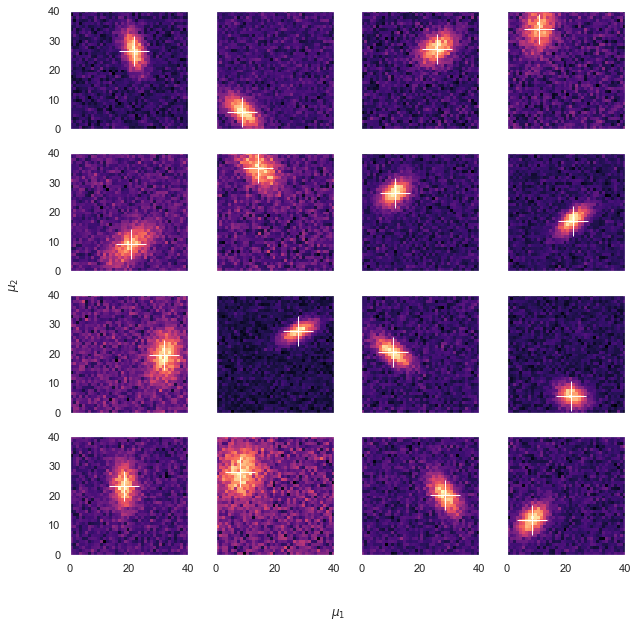

In [10]:
# Sample image
plot_multiple_data(x_train.numpy(), y_train.numpy(), np.zeros(y_train.shape))

Training sample $(D_{ij}, W_{ij}) \to \vec{\mu}$ using torch

In [9]:
class DNN_Torch(torch.nn.Sequential):
    
    def __init__(self, *n_nodes, activation=torch.nn.ReLU, drop=False):
        super(DNN_Torch, self).__init__()
        
        n_inputs = n_nodes[:-1]
        n_outputs = n_nodes[1:]
        
        for depth, (n_inp, n_out) in enumerate(zip(n_inputs, n_outputs)):
            self.add_module(f'LYR{depth}', torch.nn.Linear(n_inp, n_out))
            
            if depth < len(n_inputs) - 1:
                self.add_module(f'ACT{depth}', activation())
            
            if drop: 
                self.add_module(f'DRP{depth}', torch.nn.Dropout(p=0.005))

In [40]:
class DNN(torch.nn.Module):
    
    def __init__(self, *n_nodes, activation=torch.nn.ReLU, drop=False):
        super(DNN, self).__init__()
        
        self.activation = activation
        
        n_inputs = n_nodes[:-1]
        n_outputs = n_nodes[1:]
        
        self.hidden = torch.nn.ModuleList()
        
        for depth in range(len(n_nodes[:-1]) - 1):
            self.hidden.append(torch.nn.Linear(n_nodes[depth], n_nodes[depth + 1]))
        
        self.out = torch.nn.Linear(n_nodes[-2], n_nodes[-1])
        
    def forward(self, x):
        
        for layer in self.hidden:
            x = self.activation()(layer(x))
        
        x = self.out(x)
        x[:, -1] = torch.tanh(x[:, -1])
        return x
    
class weightConstraint(object):
    def __init__(self):
        pass
    
    def __call__(self, module):
        if hasattr(module, 'weight'):
            w = module.weight.data
            w[:, -1] = w[:, -1].clamp(-1.0, 1.0)
            module.weight.data = w

In [12]:
def learn(model, n_epochs=100, batch_size=200, learning_rate=0.05,
          loss_slice=slice(None, None), n_print=5):
    
    print(f'Model has {np.sum([np.prod(P.shape) for P in model.parameters()])} parameters.')
    loader = torch.utils.data.DataLoader(torch_train_data, batch_size=batch_size, shuffle=True)
    print(f'Data has {np.prod(loader.dataset.tensors[0].shape)} values.')
    
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    x_test, y_test = torch_test_data.tensors
    train_loss, test_loss = list(), list()
    
    print_at = np.round((1 + np.arange(n_print)) / n_print * n_epochs).astype(int)
    
    for epoch in range(n_epochs):
        model.train()
        
        for x_train, y_train in loader:
            y_pred = model(x_train)
            loss = loss_fn(y_pred[:,loss_slice], y_train[:,loss_slice])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        train_loss.append(float(loss.data))
        model.eval()
        
        y_pred = model(x_test)
        test_loss.append(float(loss_fn(y_pred[:,loss_slice], y_test[:,loss_slice]).data))
        
        if epoch + 1 == print_at[0]:
            print(f'EPOCH {epoch + 1:5d}: TRAIN {train_loss[-1]:.5f} TEST {test_loss[-1]:.5f}')
            print_at = print_at[1:]
            
    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, '.', label='TRAIN')
    plt.plot(test_loss, '.', label='TEST')
    plt.xlabel('Number of Epochs')
    plt.ylabel('MSE Loss')
    plt.yscale('log')
    plt.legend()
    
    return train_loss, test_loss, y_pred.detach()

Model has 218685 parameters.
Data has 160000000 values.
EPOCH    20: TRAIN 0.40002 TEST 0.37092
EPOCH    40: TRAIN 0.08348 TEST 0.09884
EPOCH    60: TRAIN 0.06953 TEST 0.08899
EPOCH    80: TRAIN 0.05359 TEST 0.08460
EPOCH   100: TRAIN 0.04127 TEST 0.05254


AttributeError: 'PathCollection' object has no property 'ms'

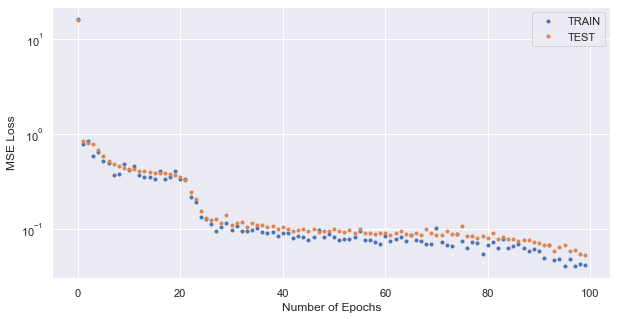

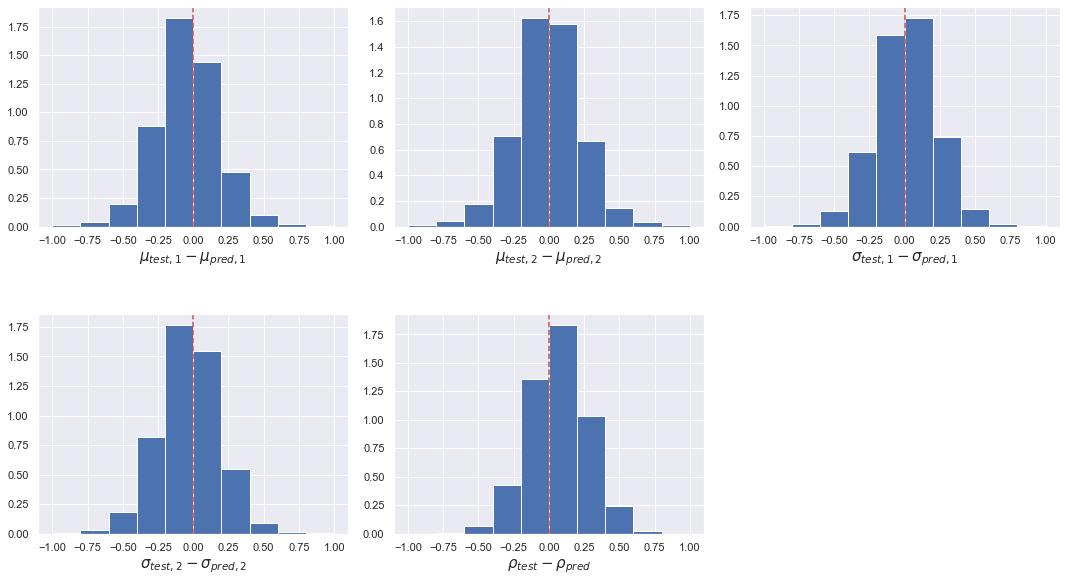

In [35]:
torch.manual_seed(123)
model = DNN(x_train.size(1), 100, 100, 140, 140, 100, y_train.size(1))
#constraints = weightConstraint()
#model._modules['out'].apply(constraints)
train_loss, test_loss, y_pred = learn(model, learning_rate=0.001, n_epochs=100, batch_size=300)

plot_histogram(y_test.numpy(), y_pred.numpy())
plot_scatter(y_test.numpy(), y_pred.numpy())
plot_multiple_data(x_test.numpy(), y_test.numpy(), y_pred.numpy())
draw_ellipse_cov(y_test.numpy(), y_pred.numpy())
plot_residual(y_test.numpy(), y_pred.numpy())

z
Model has 218685 parameters.
Data has 160000000 values.
EPOCH    20: TRAIN 0.43171 TEST 0.42432
EPOCH    40: TRAIN 0.10252 TEST 0.11176
EPOCH    60: TRAIN 0.07426 TEST 0.08728
EPOCH    80: TRAIN 0.06471 TEST 0.08038
EPOCH   100: TRAIN 0.06943 TEST 0.07622


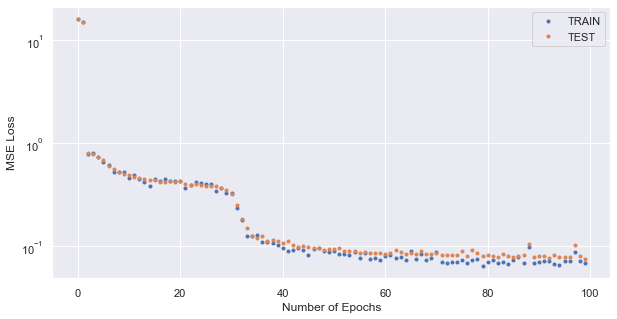

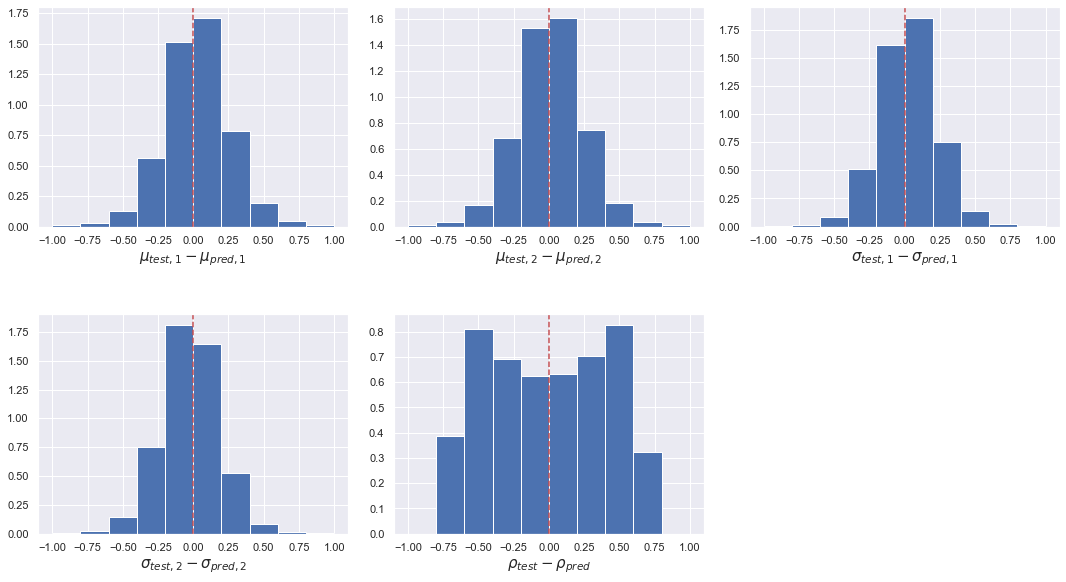

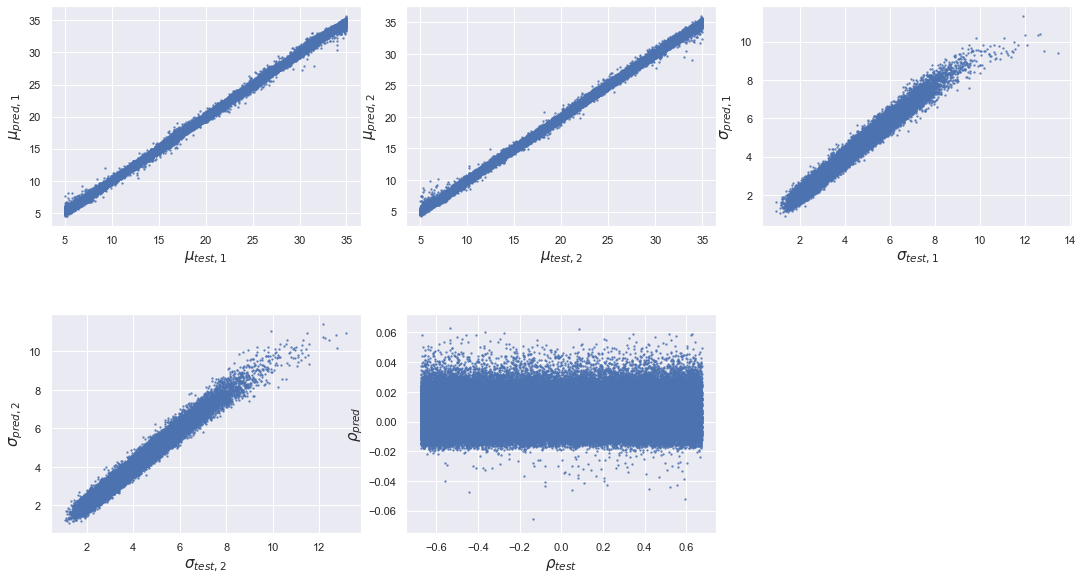

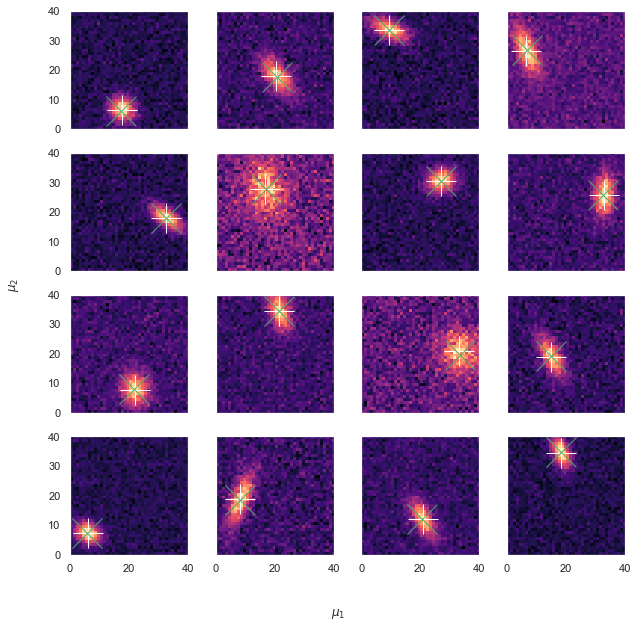

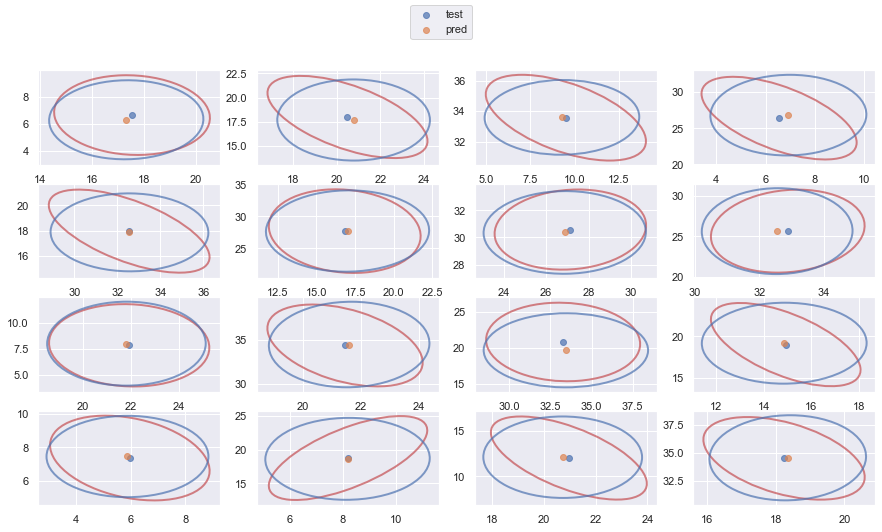

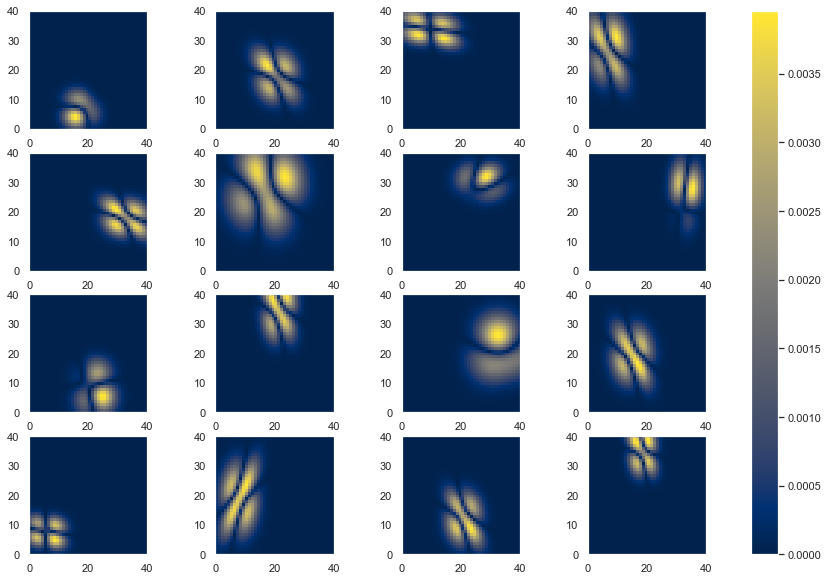

In [39]:
torch.manual_seed(123)
model = DNN(x_train.size(1), 100, 100, 140, 140, 100, y_train.size(1))
constraints = weightConstraint()
model._modules['out'].apply(constraints)
train_loss, test_loss, y_pred = learn(model, learning_rate=0.001, n_epochs=100, batch_size=400)

plot_histogram(y_test.numpy(), y_pred.numpy())
plot_scatter(y_test.numpy(), y_pred.numpy())
plot_multiple_data(x_test.numpy(), y_test.numpy(), y_pred.numpy())
draw_ellipse_cov(y_test.numpy(), y_pred.numpy())
plot_residual(y_test.numpy(), y_pred.numpy())

Model has 1304005 parameters.
Data has 160000000 values.
EPOCH    20: TRAIN 0.06410 TEST 0.07518
EPOCH    40: TRAIN 0.03373 TEST 0.03193
EPOCH    60: TRAIN 0.01484 TEST 0.02873
EPOCH    80: TRAIN 0.01909 TEST 0.03354
EPOCH   100: TRAIN 0.01161 TEST 0.02540


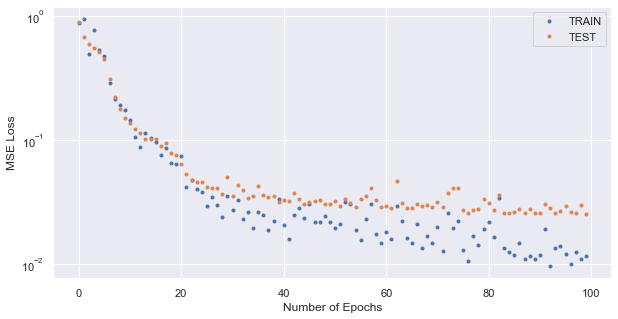

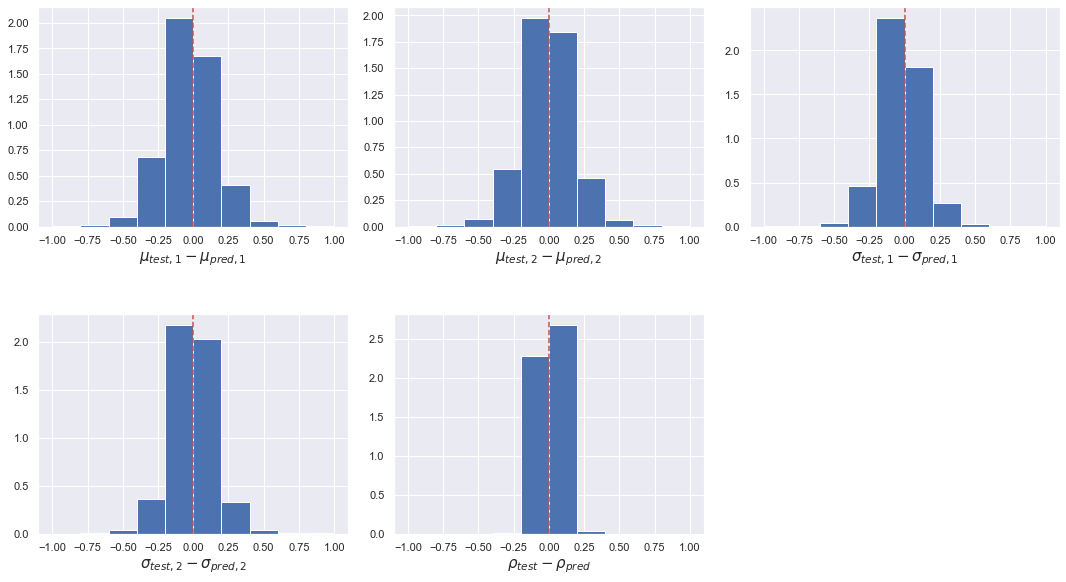

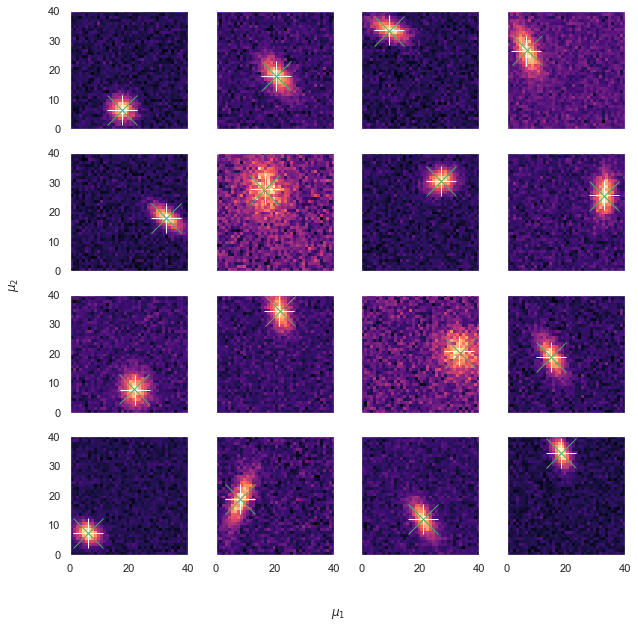

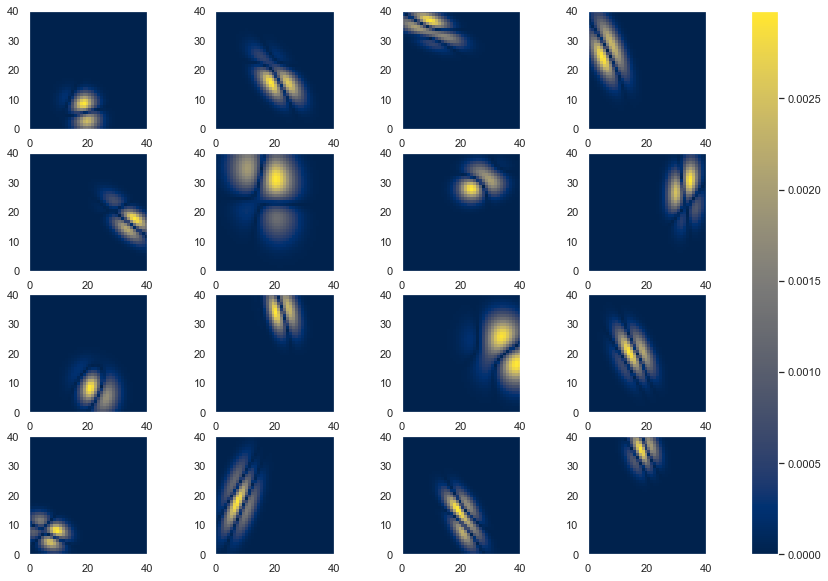

In [42]:
torch.manual_seed(123)
model = DNN(x_train.size(1), 500, 500, 500, y_train.size(1))
#constraints = weightConstraint()
#model._modules['out'].apply(constraints)
train_loss, test_loss, y_pred = learn(model, learning_rate=0.001, n_epochs=100, batch_size=300)

plot_histogram(y_test.numpy(), y_pred.numpy())
plot_scatter(y_test.numpy(), y_pred.numpy())
plot_multiple_data(x_test.numpy(), y_test.numpy(), y_pred.numpy())
draw_ellipse_cov(y_test.numpy(), y_pred.numpy())
plot_residual(y_test.numpy(), y_pred.numpy())

Model has 1304005 parameters.
Data has 160000000 values.
EPOCH    20: TRAIN 0.10276 TEST 0.10928
EPOCH    40: TRAIN 0.03964 TEST 0.05772
EPOCH    60: TRAIN 0.03601 TEST 0.04076
EPOCH    80: TRAIN 0.02131 TEST 0.03996
EPOCH   100: TRAIN 0.02719 TEST 0.03526


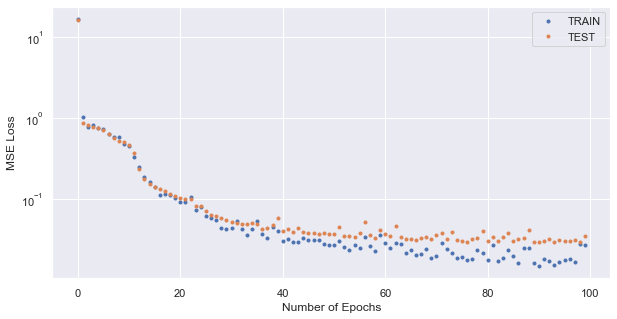

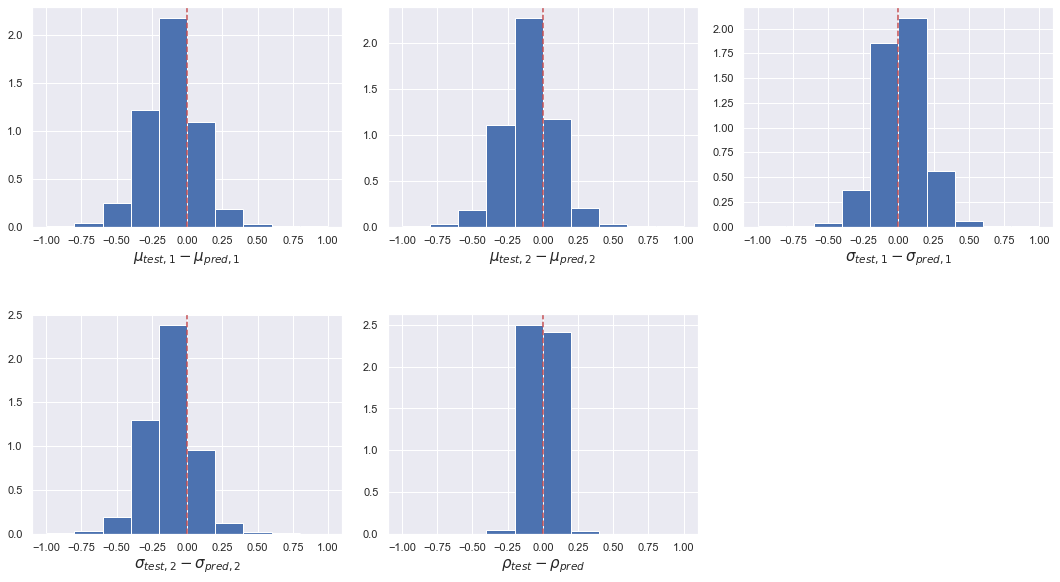

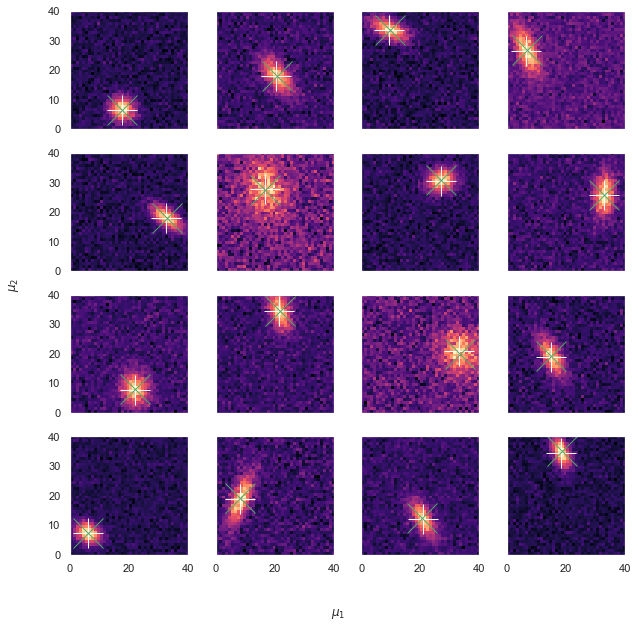

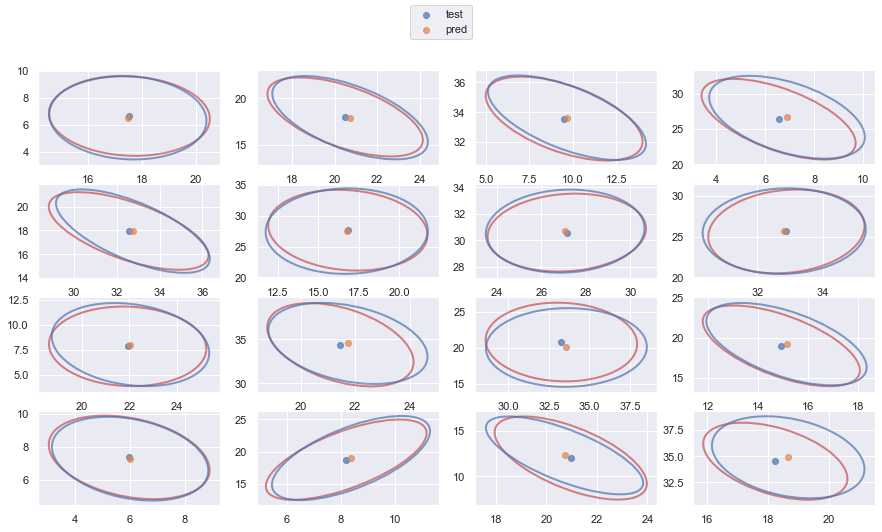

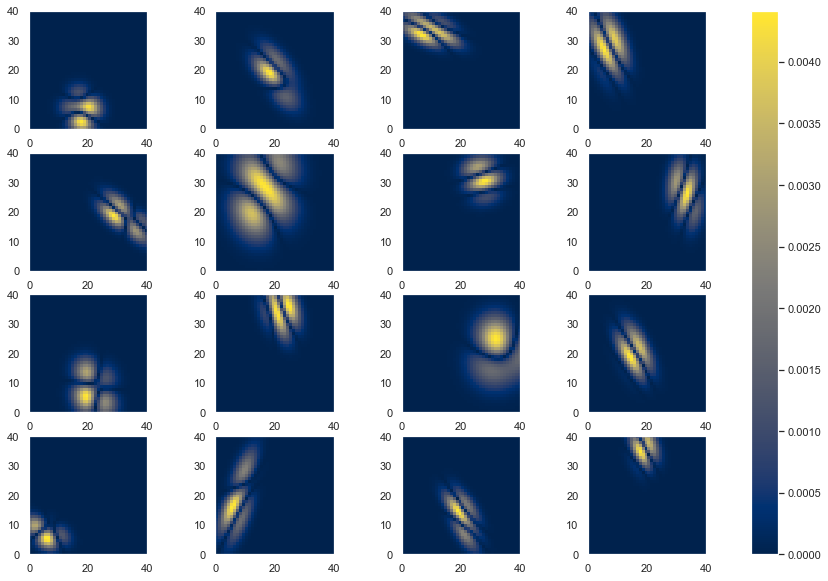

In [43]:
torch.manual_seed(123)
model = DNN(x_train.size(1), 500, 500, 500, y_train.size(1))
#constraints = weightConstraint()
#model._modules['out'].apply(constraints)
train_loss, test_loss, y_pred = learn(model, learning_rate=0.001, n_epochs=100, batch_size=500)

plot_histogram(y_test.numpy(), y_pred.numpy())
plot_scatter(y_test.numpy(), y_pred.numpy())
plot_multiple_data(x_test.numpy(), y_test.numpy(), y_pred.numpy())
draw_ellipse_cov(y_test.numpy(), y_pred.numpy())
plot_residual(y_test.numpy(), y_pred.numpy())

Model has 1304005 parameters.
Data has 160000000 values.
EPOCH     8: TRAIN 0.57436 TEST 0.57210
EPOCH    16: TRAIN 0.14172 TEST 0.14049
EPOCH    24: TRAIN 0.07298 TEST 0.08188
EPOCH    32: TRAIN 0.05368 TEST 0.05067
EPOCH    40: TRAIN 0.03964 TEST 0.05772


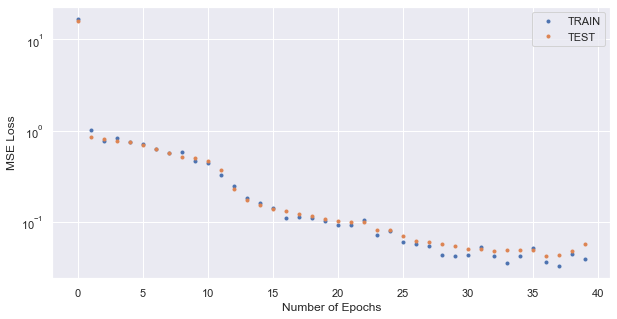

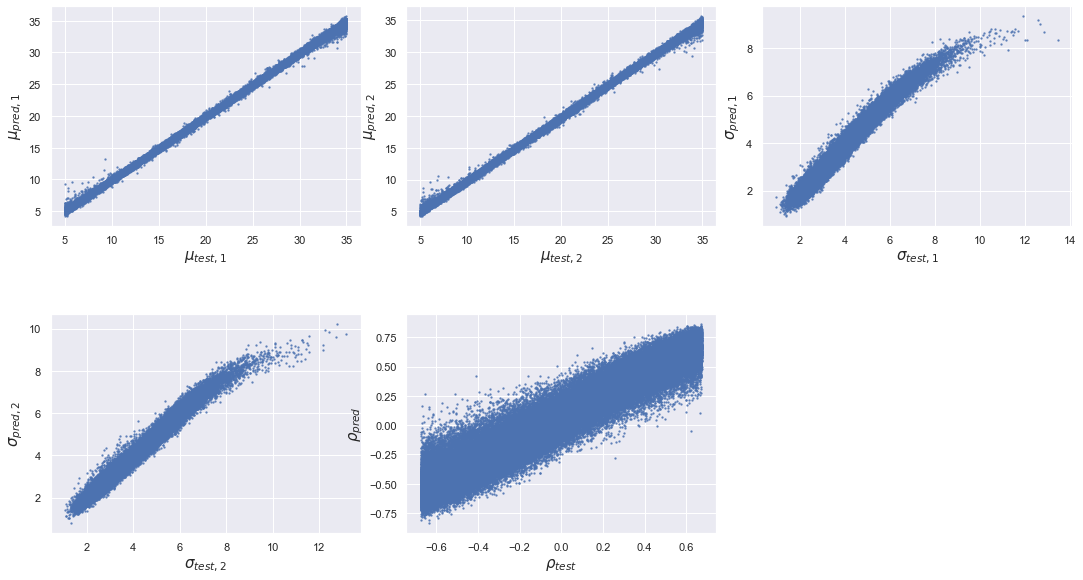

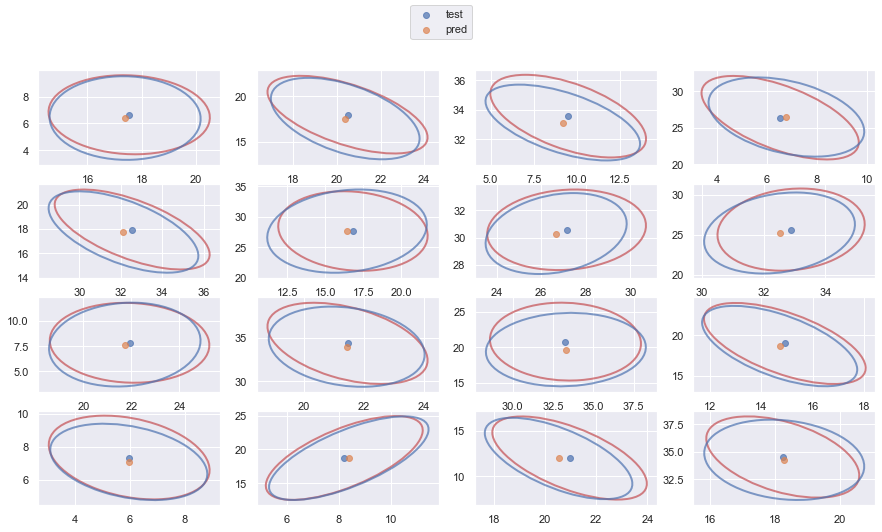

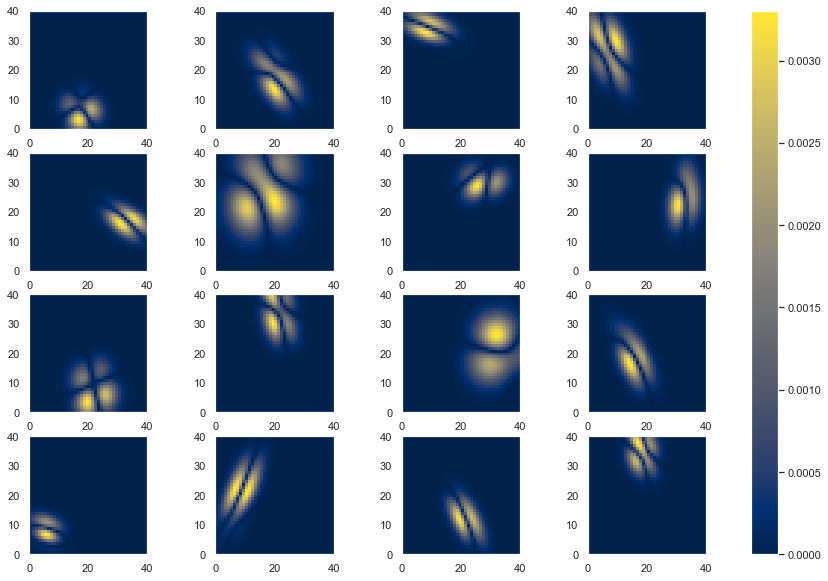

In [44]:
torch.manual_seed(123)
model = DNN(x_train.size(1), 500, 500, 500, y_train.size(1))
#constraints = weightConstraint()
#model._modules['out'].apply(constraints)
train_loss, test_loss, y_pred = learn(model, learning_rate=0.001, n_epochs=40, batch_size=500)

plot_histogram(y_test.numpy(), y_pred.numpy())
plot_scatter(y_test.numpy(), y_pred.numpy())
plot_multiple_data(x_test.numpy(), y_test.numpy(), y_pred.numpy())
draw_ellipse_cov(y_test.numpy(), y_pred.numpy())
plot_residual(y_test.numpy(), y_pred.numpy())

Model has 1304005 parameters.
Data has 160000000 values.
EPOCH    20: TRAIN 0.31408 TEST 0.32360
EPOCH    40: TRAIN 0.07003 TEST 0.07702
EPOCH    60: TRAIN 0.03079 TEST 0.04465
EPOCH    80: TRAIN 0.02727 TEST 0.03552
EPOCH   100: TRAIN 0.02202 TEST 0.03495


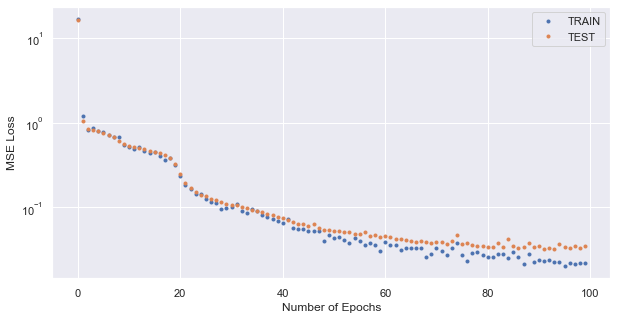

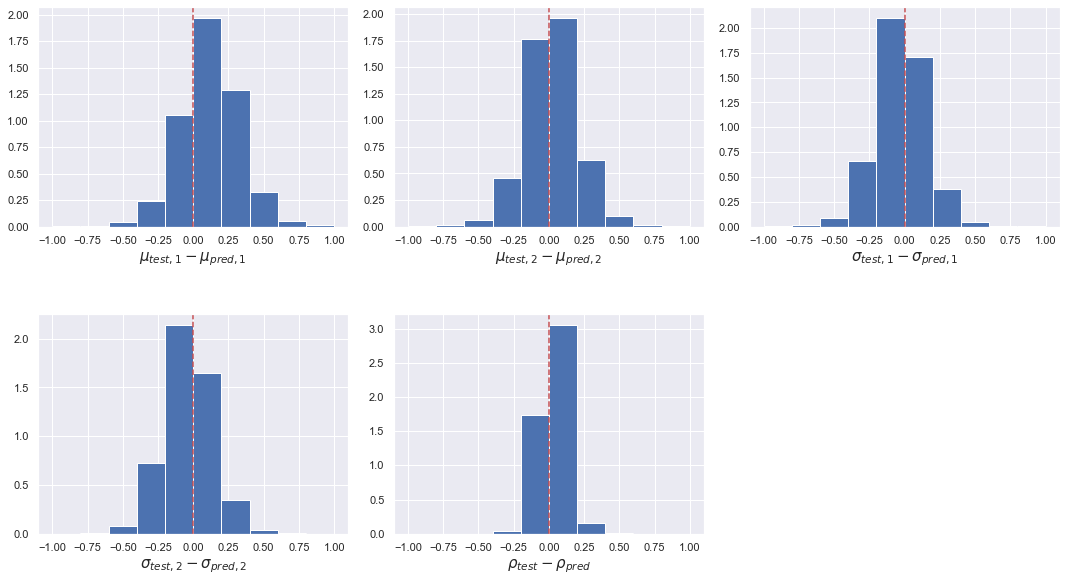

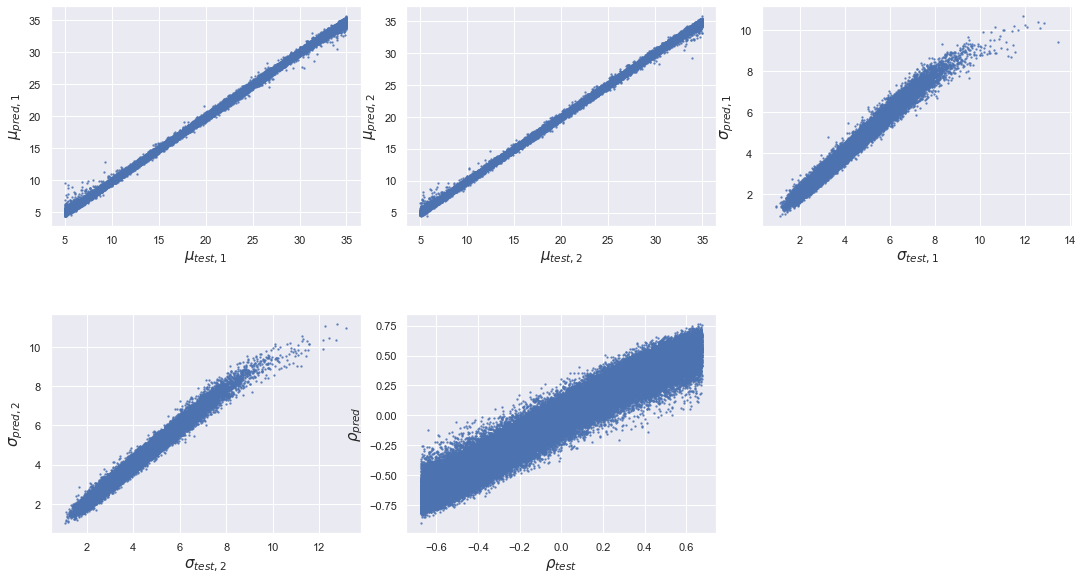

In [45]:
torch.manual_seed(123)
model = DNN(x_train.size(1), 500, 500, 500, y_train.size(1))
#constraints = weightConstraint()
#model._modules['out'].apply(constraints)
train_loss, test_loss, y_pred = learn(model, learning_rate=0.0005, n_epochs=100, batch_size=500)

plot_histogram(y_test.numpy(), y_pred.numpy())
plot_scatter(y_test.numpy(), y_pred.numpy())
plot_multiple_data(x_test.numpy(), y_test.numpy(), y_pred.numpy())
draw_ellipse_cov(y_test.numpy(), y_pred.numpy())
plot_residual(y_test.numpy(), y_pred.numpy())

Model has 1554505 parameters.
Data has 160000000 values.
EPOCH    20: TRAIN 0.17226 TEST 0.17088
EPOCH    40: TRAIN 0.04771 TEST 0.05430
EPOCH    60: TRAIN 0.02001 TEST 0.03060
EPOCH    80: TRAIN 0.02109 TEST 0.02588
EPOCH   100: TRAIN 0.01825 TEST 0.02641


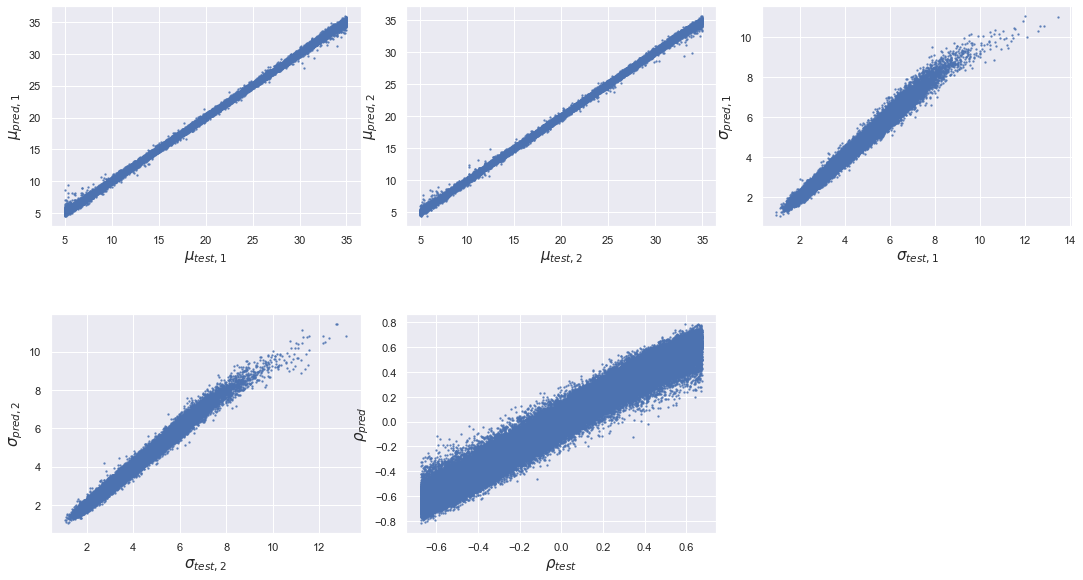

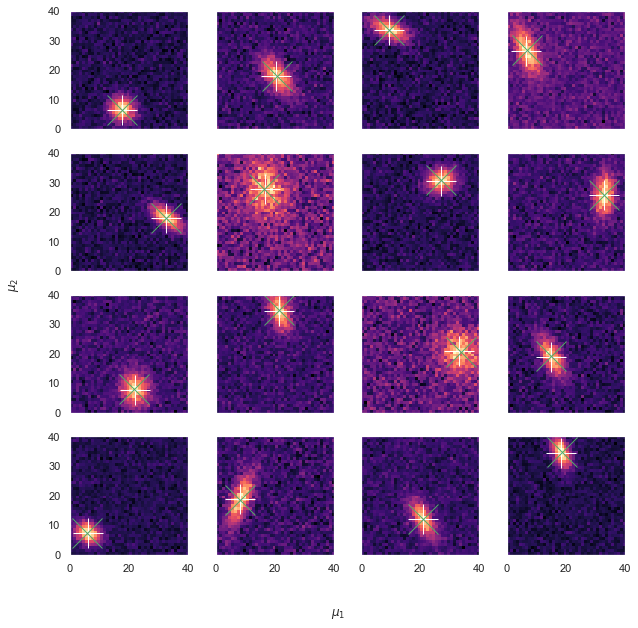

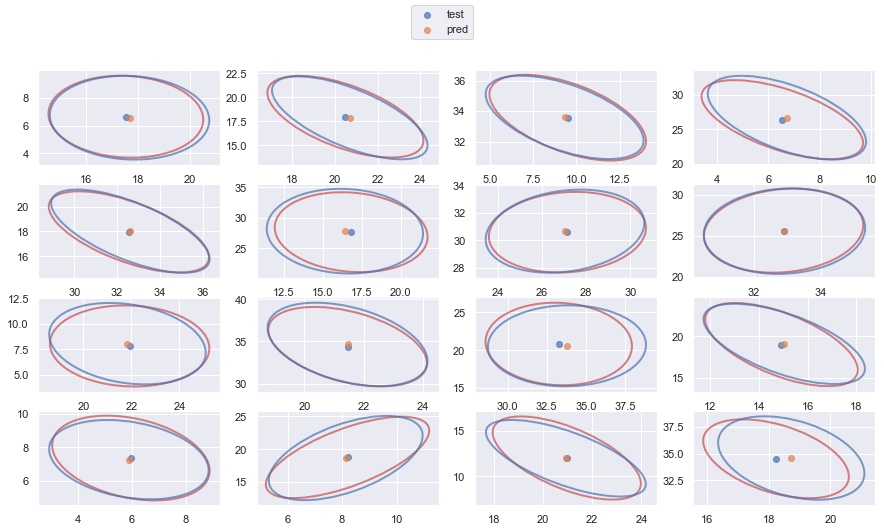

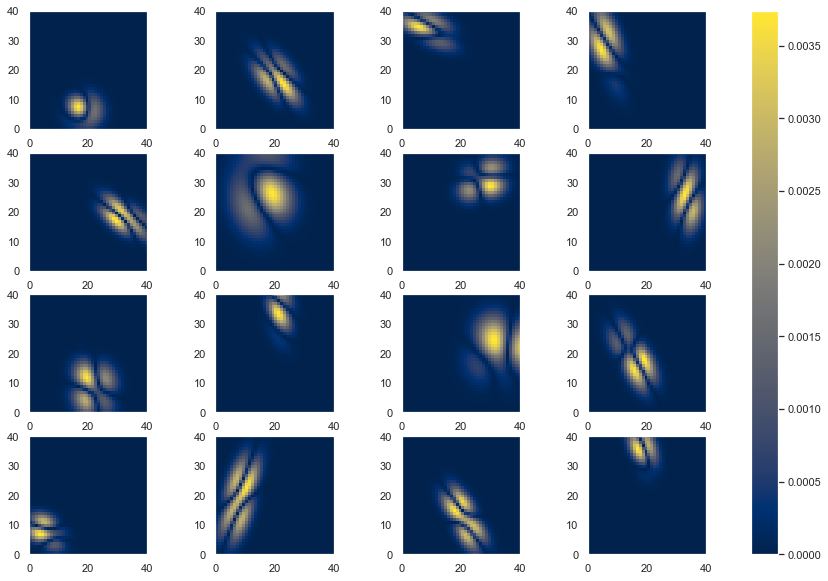

In [46]:
torch.manual_seed(123)
model = DNN(x_train.size(1), 500, 500, 500, 500, y_train.size(1))
#constraints = weightConstraint()
#model._modules['out'].apply(constraints)
train_loss, test_loss, y_pred = learn(model, learning_rate=0.0005, n_epochs=100, batch_size=500)

plot_histogram(y_test.numpy(), y_pred.numpy())
plot_scatter(y_test.numpy(), y_pred.numpy())
plot_multiple_data(x_test.numpy(), y_test.numpy(), y_pred.numpy())
draw_ellipse_cov(y_test.numpy(), y_pred.numpy())
plot_residual(y_test.numpy(), y_pred.numpy())

Model has 1805005 parameters.
Data has 160000000 values.
EPOCH    20: TRAIN 0.36575 TEST 0.40494
EPOCH    40: TRAIN 0.32586 TEST 0.34538
EPOCH    60: TRAIN 0.05994 TEST 0.06916
EPOCH    80: TRAIN 0.05232 TEST 0.05890
EPOCH   100: TRAIN 0.01399 TEST 0.02626


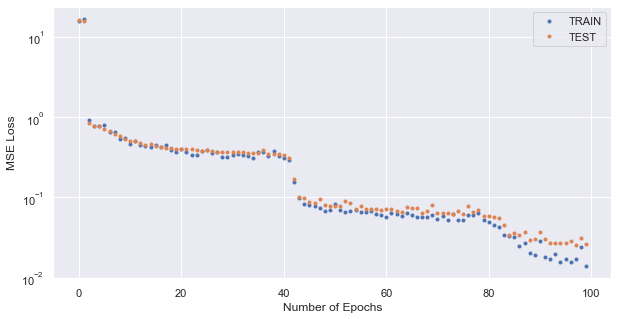

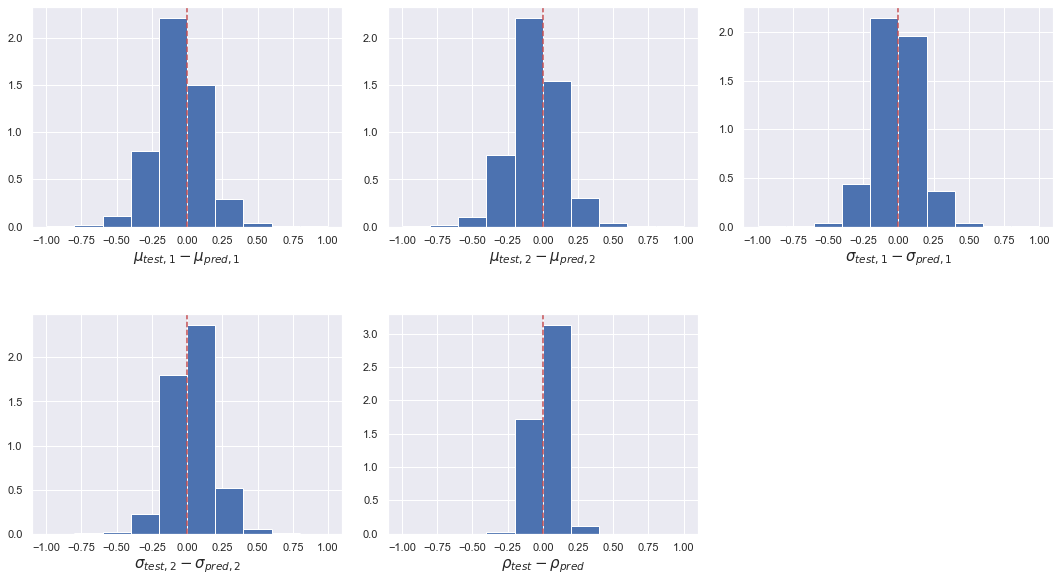

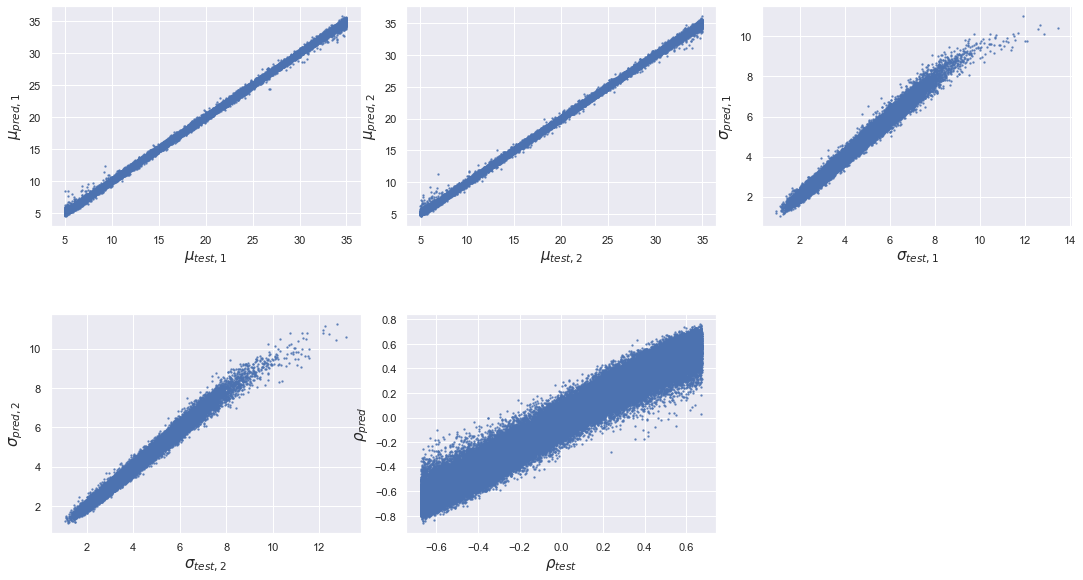

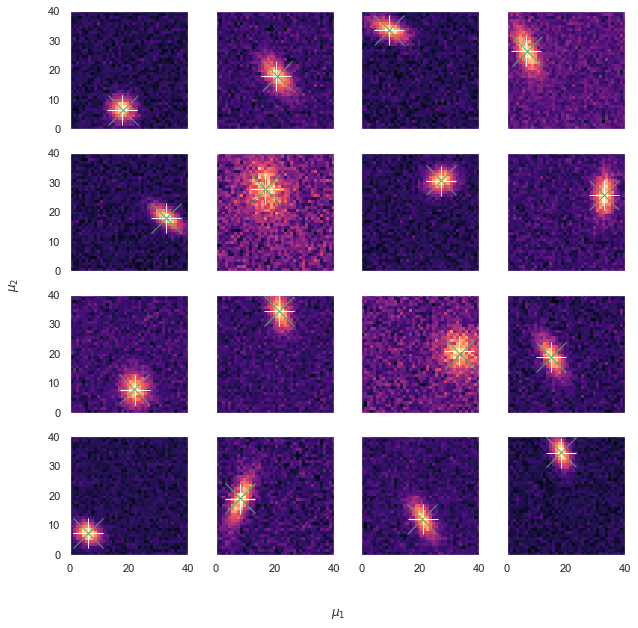

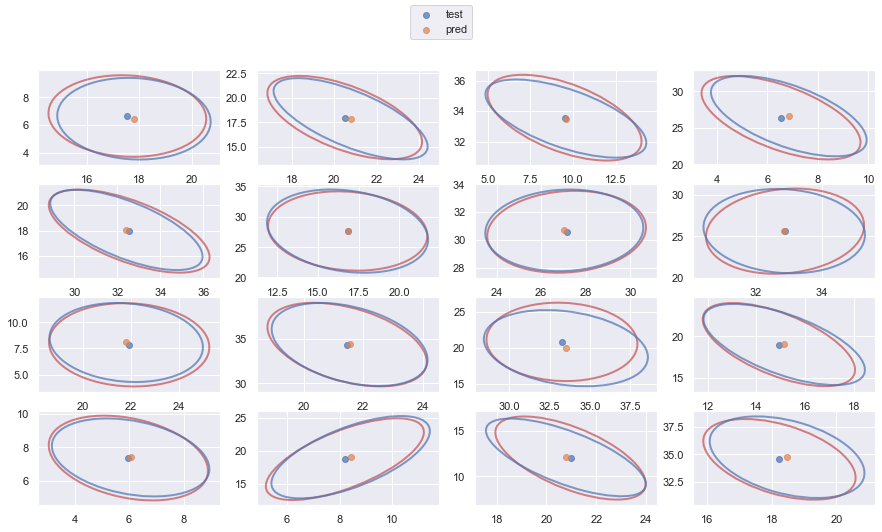

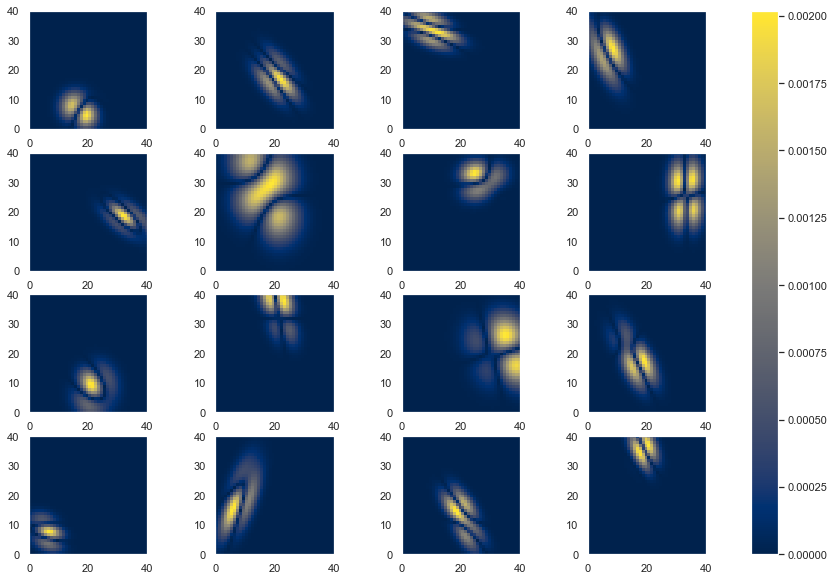

In [47]:
torch.manual_seed(123)
model = DNN(x_train.size(1), 500, 500, 500, 500, 500, y_train.size(1))
#constraints = weightConstraint()
#model._modules['out'].apply(constraints)
train_loss, test_loss, y_pred = learn(model, learning_rate=0.0005, n_epochs=100, batch_size=500)

plot_histogram(y_test.numpy(), y_pred.numpy())
plot_scatter(y_test.numpy(), y_pred.numpy())
plot_multiple_data(x_test.numpy(), y_test.numpy(), y_pred.numpy())
draw_ellipse_cov(y_test.numpy(), y_pred.numpy())
plot_residual(y_test.numpy(), y_pred.numpy())